In [ ]:
# -*- coding: utf-8 -*-
"""Intro to Urban Project .ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1TMFpwj-eTLAHQDC2ejpehcMEkdpsr7r-
"""

from google.colab import drive

drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
from __future__ import division
from IPython.display import display
from sklearn.compose import make_column_transformer
import matplotlib
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn as sklearn
import sklearn.impute as impute
from pandas import DataFrame
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from collections import Counter
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import sklearn.model_selection as modelsel
import sklearn.feature_selection as featsel
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.tree as tree
from sklearn.utils import shuffle
import pydotplus
import collections
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preproc
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from math import log, e
from sklearn.preprocessing import add_dummy_feature
from random import sample
# data_directory = '/content/drive/Shareddrives/CS5834_Project/datasets'
# traffic_vol = pd.read_csv(f'{data_directory}/Traffic_Volume.csv') #contains ADT for Montgomery County
# streets = pd.read_csv(f'{data_directory}/Streets.csv')
# speed_limits = pd.read_csv(f'{data_directory}/VDOT_Posted_Speed_Limits.csv')
# aadt_blacksburg = pd.read_excel(f'{data_directory}/AADT_150_Blacksburg_2021.xlsx')
# avg_daily_traffic = pd.read_csv(f'{data_directory}/Average_Daily_Traffic_Count.csv') #contains ADT for Montgomery County
# weather_report = pd.read_csv(f'{data_directory}/weather_2008_2022.csv')



# Loading Datasets

In [ ]:
data_directory = '/content/drive/Shareddrives/CS5834_Project/datasets'
traffic_vol = pd.read_csv(f'{data_directory}/Traffic_Volume.csv') #contains ADT for Montgomery County
streets = pd.read_csv(f'{data_directory}/Streets.csv')
speed_limits = pd.read_csv(f'{data_directory}/VDOT_Posted_Speed_Limits.csv')
aadt_blacksburg = pd.read_excel(f'{data_directory}/AADT_150_Blacksburg_2021.xlsx')
avg_daily_traffic = pd.read_csv(f'{data_directory}/Average_Daily_Traffic_Count.csv') #contains ADT for Montgomery County
weather_report = pd.read_csv(f'{data_directory}/weather_2008_2022.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,32,46,47,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Looking to see if the speed limits include any cities of interest (they did not)

In [ ]:
speed_limits['FROM_DISTRICT'].unique()

array(['Richmond', 'Lynchburg', 'Bristol', 'Culpeper', 'Hampton Roads',
       'Salem', 'Fredericksburg', 'Staunton', 'Northern Virginia', nan],
      dtype=object)

## Remove unnecessary features from the weather data

In [ ]:

weather_report.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DAPR',
       'MDPR', 'TOBS', 'WESD', 'WESF',
       'WT01', 'WT03', 'WT04', 'WT05', 'WT06', 'WT11'], axis=1, inplace=True)
weather_report.columns

Index(['DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN'], dtype='object')

## Convert dates into Y-M-D for consistency across data to make merging simple

In [ ]:
areas_of_interest = ["Montgomery County", "Town of Blacksburg", "Town of Christiansburg"]
traffic_vol["DATA_DATE"] = pd.to_datetime(traffic_vol["DATA_DATE"], format="%Y-%m-%d").dt.normalize()
# traffic_vol['DATA_DATE'].min()
traffic_vol["DATA_DATE"] = traffic_vol['DATA_DATE'].dt.tz_localize(None)

# traffic_vol = traffic_vol.loc[(traffic_vol["FROM_JURISDICTION"].isin(areas_of_interest)), :]
traffic_vol["DATA_DATE"]

0        2018-07-10
1        2021-01-01
2        2021-11-10
3        2015-07-02
4        2012-09-12
            ...    
116514   2021-08-12
116515   2017-10-05
116516   2021-01-01
116517   2013-05-13
116518   2017-06-07
Name: DATA_DATE, Length: 116519, dtype: datetime64[ns]

In [ ]:
avg_daily_traffic['DATA_DATE'] = pd.to_datetime(avg_daily_traffic["DATA_DATE"],dayfirst=True, errors='coerce')
avg_daily_traffic['DATA_DATE']


0      2011-10-26
1      2010-05-25
2      2009-10-09
3      2006-09-25
4      2006-11-30
          ...    
8317   2009-05-22
8318   2012-01-01
8319   2012-01-01
8320   2006-11-20
8321   2010-04-30
Name: DATA_DATE, Length: 8322, dtype: datetime64[ns]

In [ ]:
weather_report['DATE'] = pd.to_datetime(weather_report['DATE'], dayfirst=True,format="%Y-%m-%d", errors='coerce')
weather_report['DATE']

0       2008-01-01
1       2008-01-02
2       2008-01-03
3       2008-01-04
4       2008-01-05
           ...    
63819   2016-01-05
63820   2016-01-06
63821   2016-01-07
63822   2016-09-14
63823   2016-09-17
Name: DATE, Length: 63824, dtype: datetime64[ns]

## Looking at how many features how our traffic datasets have and determining what needs to be dropped to make them the same as well as what labels need to be changed

In [ ]:
# traffic_vol.drop(['LINKID'], axis=1, inplace=True)
print(f"{len(traffic_vol.columns)=}{traffic_vol.columns=}")
print(f"{len(avg_daily_traffic.columns)=},{avg_daily_traffic.columns=}")

len(traffic_vol.columns)=42traffic_vol.columns=Index(['OBJECTID', 'LINKID', 'DATA_DATE', 'ROUTE_COMMON_NAME', 'ROUTE_NAME',
       'HTRIS_ID', 'ROUTE_ALIAS', 'START_LABEL', 'END_LABEL', 'ADT',
       'ADT_QUALITY', 'PERCENT_4_TIRE', 'PERCENT_BUS', 'PERCENT_TRUCK_2_AXLE',
       'PERCENT_TRUCK_3_AXLE', 'PERCENT_TRUCK_1_TRAIL',
       'PERCENT_TRUCK_2_TRAIL', 'CLASS_QUALITY_CODE', 'K_FACTOR',
       'K_FACTOR_QUALITY_CODE', 'DIRECTION_FACTOR', 'AAWDT',
       'AAWDT_QUALITY_CODE', 'LOC_COMP_DIRECTIONALITY_NAME',
       'ROUTE_FROM_MEASURE', 'FROM_JURISDICTION', 'ROUTE_TO_MEASURE',
       'TO_JURISDICTION', 'PEAK_SINGLE_UNIT_TRUCK', 'PEAK_COMBINATION_TRUCK',
       'EVENT_SOURCE_ID', 'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID',
       'MAXIMUMSCALEDENOMINATOR', 'ROUTE_COMMON_NAME_ADT', 'FROM_DISTRICT',
       'TO_DISTRICT', 'RTE_TYPE_CD', 'RTE_ID', 'DATA_CUSTODIAN_EMAIL',
       'METADATA_URL', 'Shape__Length'],
      dtype='object')
len(avg_daily_traffic.columns)=39,avg_daily_traffic.colum

In [ ]:
import re
seen = list()
for i, col in enumerate(traffic_vol.columns):
  for elem in avg_daily_traffic.columns:
    if re.search(elem, col) and elem not in seen:
      seen.append(elem)
      print(f"{elem}:{col}")

OBJECTID:OBJECTID
DATA_DATE:DATA_DATE
ROUTE_COMM:ROUTE_COMMON_NAME
ROUTE_NAME:ROUTE_NAME
HTRIS_ID:HTRIS_ID
ROUTE_ALIA:ROUTE_ALIAS
START_LABE:START_LABEL
END_LABEL:END_LABEL
ADT:ADT
ADT_QUALIT:ADT_QUALITY
PERCENT_4_:PERCENT_4_TIRE
PERCENT_BU:PERCENT_BUS
PERCENT_TR:PERCENT_TRUCK_2_AXLE
CLASS_QUAL:CLASS_QUALITY_CODE
K_FACTOR:K_FACTOR
K_FACTOR_Q:K_FACTOR_QUALITY_CODE
DIRECTION_:DIRECTION_FACTOR
AAWDT:AAWDT
AAWDT_QUAL:AAWDT_QUALITY_CODE
LOC_COMP_D:LOC_COMP_DIRECTIONALITY_NAME
ROUTE_FROM:ROUTE_FROM_MEASURE
FROM_JURIS:FROM_JURISDICTION
ROUTE_TO_M:ROUTE_TO_MEASURE
TO_JURISDI:TO_JURISDICTION
PEAK_SINGL:PEAK_SINGLE_UNIT_TRUCK
PEAK_COMBI:PEAK_COMBINATION_TRUCK
EVENT_SOUR:EVENT_SOURCE_ID
EVENT_LOCA:EVENT_LOCATION_ID
EVENT_COMP:EVENT_COMPONENT_ID
MAXIMUMSCA:MAXIMUMSCALEDENOMINATOR
DATA_CUSTO:DATA_CUSTODIAN_EMAIL
METADATA_U:METADATA_URL


In [ ]:

avg_daily_traffic.rename(columns = {'ROUTE_COMM':'ROUTE_COMMON_NAME', 'ROUTE_ALIA': 'ROUTE_ALIAS', 'ADT_QUALIT': 'ADT_QUALITY', 'PERCENT_4_': 'PERCENT_4_TIRE', 'PERCENT_BU': 'PERCENT_BUS', 'CLASS_QUAL':'CLASS_QUALITY_CODE', 'K_FACTOR_Q':'K_FACTOR_QUALITY_CODE', 'DIRECTION_':'DIRECTION_FACTOR',
                                    'EVENT_SOUR':'EVENT_SOURCE_ID',
                                    'EVENT_LOCA':'EVENT_LOCATION_ID',
                                    'EVENT_COMP':'EVENT_COMPONENT_ID',
                                    'MAXIMUMSCA':'MAXIMUMSCALEDENOMINATOR',
                                    'METADATA_U':'METADATA_URL',
                                    'DATA_CUSTO':'DATA_CUSTODIAN_EMAIL',
                                    'AAWDT_QUAL':'AAWDT_QUALITY_CODE',
                                    'START_LABE':'START_LABEL',
                                    'LOC_COMP_D':'LOC_COMP_DIRECTIONALITY_NAME',
                                    'ROUTE_FROM':'ROUTE_FROM_MEASURE',
                                    'FROM_JURIS':'FROM_JURISDICTION',
                                    'ROUTE_TO_M':'ROUTE_TO_MEASURE',
                                    'TO_JURISDI':'TO_JURISDICTION',
                                    'PEAK_SINGL':'PEAK_SINGLE_UNIT_TRUCK',
                                    'PEAK_COMBI':'PEAK_COMBINATION_TRUCK',
                                    'PERCENT_TR':'PERCENT_TRUCK_2_AXLE',
                                    'PERCENT__3':'PERCENT_TRUCK_3_AXLE', 
                                    'PERCENT__1':'PERCENT_TRUCK_1_TRAIL',
                                    'PERCENT__2':'PERCENT_TRUCK_2_TRAIL',
                                    'Shape_Length': 'Shape__Length'}, inplace = True)


In [ ]:
print(len(avg_daily_traffic.columns))
avg_daily_traffic.columns


39


Index(['OBJECTID', 'DATA_DATE', 'ROUTE_COMMON_NAME', 'HTRIS_ID', 'ROUTE_ALIAS',
       'START_LABEL', 'END_LABEL', 'ADT', 'ADT_QUALITY', 'PERCENT_4_TIRE',
       'PERCENT_BUS', 'PERCENT_TRUCK_2_AXLE', 'PERCENT_TRUCK_1_TRAIL',
       'PERCENT_TRUCK_2_TRAIL', 'PERCENT_TRUCK_3_AXLE', 'CLASS_QUALITY_CODE',
       'K_FACTOR', 'K_FACTOR_QUALITY_CODE', 'DIRECTION_FACTOR', 'AAWDT',
       'AAWDT_QUALITY_CODE', 'LOC_COMP_DIRECTIONALITY_NAME',
       'ROUTE_FROM_MEASURE', 'FROM_JURISDICTION', 'ROUTE_TO_MEASURE',
       'TO_JURISDICTION', 'PEAK_SINGLE_UNIT_TRUCK', 'PEAK_COMBINATION_TRUCK',
       'DATA_CUSTODIAN_EMAIL', 'METADATA_URL', 'ROUTE_NAME', 'EVENT_SOURCE_ID',
       'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID', 'MAXIMUMSCALEDENOMINATOR',
       'ROUTE_CO_1', 'DATA_YEARO', 'Shape_STLength__', 'Shape__Length'],
      dtype='object')

In [ ]:
# traffic_vol.drop(['LINKID'], axis=1, inplace=True)
print(len(traffic_vol.columns))
traffic_vol.columns

42


Index(['OBJECTID', 'LINKID', 'DATA_DATE', 'ROUTE_COMMON_NAME', 'ROUTE_NAME',
       'HTRIS_ID', 'ROUTE_ALIAS', 'START_LABEL', 'END_LABEL', 'ADT',
       'ADT_QUALITY', 'PERCENT_4_TIRE', 'PERCENT_BUS', 'PERCENT_TRUCK_2_AXLE',
       'PERCENT_TRUCK_3_AXLE', 'PERCENT_TRUCK_1_TRAIL',
       'PERCENT_TRUCK_2_TRAIL', 'CLASS_QUALITY_CODE', 'K_FACTOR',
       'K_FACTOR_QUALITY_CODE', 'DIRECTION_FACTOR', 'AAWDT',
       'AAWDT_QUALITY_CODE', 'LOC_COMP_DIRECTIONALITY_NAME',
       'ROUTE_FROM_MEASURE', 'FROM_JURISDICTION', 'ROUTE_TO_MEASURE',
       'TO_JURISDICTION', 'PEAK_SINGLE_UNIT_TRUCK', 'PEAK_COMBINATION_TRUCK',
       'EVENT_SOURCE_ID', 'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID',
       'MAXIMUMSCALEDENOMINATOR', 'ROUTE_COMMON_NAME_ADT', 'FROM_DISTRICT',
       'TO_DISTRICT', 'RTE_TYPE_CD', 'RTE_ID', 'DATA_CUSTODIAN_EMAIL',
       'METADATA_URL', 'Shape__Length'],
      dtype='object')

In [ ]:
avg_daily_traffic.drop(['ROUTE_CO_1', 'DATA_YEARO', 'Shape_STLength__',], axis=1, inplace=True)
traffic_vol.drop(['LINKID','ROUTE_COMMON_NAME_ADT', 'FROM_DISTRICT', 'TO_DISTRICT', 'RTE_TYPE_CD', 'RTE_ID'], axis=1, inplace=True)

In [ ]:
print(len(avg_daily_traffic.columns))

print(len(traffic_vol.columns))

36
36


In [ ]:
print(len(avg_daily_traffic.columns))
after_date_traffic = avg_daily_traffic.loc[avg_daily_traffic["DATA_DATE"] >= weather_report['DATE'].min(), :]

36


## Traffic Data Combined

In [ ]:
combined_traffic_data = avg_daily_traffic.append(traffic_vol)
combined_traffic_data.rename(columns = {'DATA_DATE': 'DATE'}, inplace=True)

In [ ]:
# combined_traffic_data['DATE'] = pd.to_datetime(combined_traffic_data['DATE'], utc=False, errors='coerce')

In [ ]:
combined_traffic_data.columns

Index(['OBJECTID', 'DATE', 'ROUTE_COMMON_NAME', 'HTRIS_ID', 'ROUTE_ALIAS',
       'START_LABEL', 'END_LABEL', 'ADT', 'ADT_QUALITY', 'PERCENT_4_TIRE',
       'PERCENT_BUS', 'PERCENT_TRUCK_2_AXLE', 'PERCENT_TRUCK_1_TRAIL',
       'PERCENT_TRUCK_2_TRAIL', 'PERCENT_TRUCK_3_AXLE', 'CLASS_QUALITY_CODE',
       'K_FACTOR', 'K_FACTOR_QUALITY_CODE', 'DIRECTION_FACTOR', 'AAWDT',
       'AAWDT_QUALITY_CODE', 'LOC_COMP_DIRECTIONALITY_NAME',
       'ROUTE_FROM_MEASURE', 'FROM_JURISDICTION', 'ROUTE_TO_MEASURE',
       'TO_JURISDICTION', 'PEAK_SINGLE_UNIT_TRUCK', 'PEAK_COMBINATION_TRUCK',
       'DATA_CUSTODIAN_EMAIL', 'METADATA_URL', 'ROUTE_NAME', 'EVENT_SOURCE_ID',
       'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID', 'MAXIMUMSCALEDENOMINATOR',
       'Shape__Length'],
      dtype='object')

## Traffic data combined with weather data

In [ ]:
combined_traffic_data

OBJECTID       DATE                 ROUTE_COMMON_NAME        HTRIS_ID  \
0              1 2011-10-26         SC-905E (Franklin County)         3300905   
1              2 2010-05-25          SC-698E (Bedford County)         0900698   
2              3 2009-10-09         SC-1610E (Roanoke County)         8001610   
3              4 2006-09-25          SC-731E (Roanoke County)         8000731   
4              5 2006-11-30          SC-885N (Roanoke County)         8000885   
...          ...        ...                               ...             ...   
116514    116515 2021-08-12       SC-1121N (Middlesex County)    5901121        
116515    116516 2017-10-05            SC-674N (Giles County)    3500674        
116516    116517 2021-01-01                   VA-285U Ramp 0A    SR00285 000A   
116517    116518 2013-05-13  SC-1226E (Prince William County)    7601226        
116518    116519 2017-06-07         SC-1667E (Hanover County)    4201667        

                    ROUTE_ALIAS                START_LABEL  \
0          33-905 Standiford Rd          33-1110 Carlos Rd   
1           09-698 Villamont Rd           09-802 Lynn Lane   
2         80-1610 Martinell Ave        80-1632 Lanewood Dr   
3               80-731 Lewis Rd           80-943 Branch Rd   
4               80-885 Dover Dr                   Dead End   
...                         ...                        ...   
116514  59-1121 Sandy Bottom Dr  59-1122 Woodridge Cove Dr   
116515       35-674 Woodland Dr                   Dead End   
116516    VA 285 Exit 000A Ramp  SR 285 Tinkling Spring Rd   
116517      76-1226 Carter Lane      76-1229 Cecilia Court   
116518      42-1667 Saber Court                 Cul-de-Sac   

                      END_LABEL     ADT ADT_QUALITY  PERCENT_4_TIRE  ...  \
0           33-1112 Winding Way    50.0           R         0.00000  ...   
1          09-843 S, Level Lane   150.0           R         0.00000  ...   
2             80-1604 Poplar Dr   140.0           R         0.00000  ...   
3               80-776 Lewis Rd   330.0           R         0.00000  ...   
4                   SCL Roanoke    70.0           R         0.00000  ...   
...                         ...     ...         ...             ...  ...   
116514                 Dead End    10.0           T             NaN  ...   
116515         0.46 MN Dead End   130.0           T             NaN  ...   
116516                I-64 East  3100.0           G        93.92197  ...   
116517                 Dead End    80.0           T             NaN  ...   
116518  42-1663 Dougout Terrace   150.0           T             NaN  ...   

        PEAK_SINGLE_UNIT_TRUCK  PEAK_COMBINATION_TRUCK  \
0                      0.00000                 0.00000   
1                      0.00000                 0.00000   
2                      0.00000                 0.00000   
3                      0.00000                 0.00000   
4                      0.00000                 0.00000   
...                        ...                     ...   
116514                     NaN                     NaN   
116515                     NaN                     NaN   
116516                 0.03308                 0.03308   
116517                     NaN                     NaN   
116518                     NaN                     NaN   

                         DATA_CUSTODIAN_EMAIL  \
0       mailto:Tom.Schinkel@VDOT.Virginia.gov   
1       mailto:Tom.Schinkel@VDOT.Virginia.gov   
2       mailto:Tom.Schinkel@VDOT.Virginia.gov   
3       mailto:Tom.Schinkel@VDOT.Virginia.gov   
4       mailto:Tom.Schinkel@VDOT.Virginia.gov   
...                                       ...   
116514                                    NaN   
116515                                    NaN   
116516                                    NaN   
116517                                    NaN   
116518                                    NaN   

                                             METADATA_URL  \
0       http://coapp09/website

In [ ]:
combined_traffic_data = combined_traffic_data.loc[((combined_traffic_data['DATE'] >= weather_report['DATE'].min()) & (combined_traffic_data['DATE'] <= weather_report['DATE'].max())), :]
final_combined_traffic_data = pd.merge(combined_traffic_data,weather_report, on='DATE') 

In [ ]:
final_combined_traffic_data = final_combined_traffic_data.drop_duplicates(subset='OBJECTID').reset_index()

In [ ]:
final_combined_traffic_data.shape

(1260, 42)

## Selecting only Montgomery County datapoints

In [ ]:
areas_of_interest = ["Montgomery County", "Town of Blacksburg", "Town of Christiansburg"]
final_combined_traffic_data = final_combined_traffic_data.loc[(final_combined_traffic_data["FROM_JURISDICTION"].isin(areas_of_interest)), :]
final_combined_traffic_data['FROM_JURISDICTION'].unique()

array(['Montgomery County', 'Town of Blacksburg',
       'Town of Christiansburg'], dtype=object)

In [ ]:
from google.colab import data_table
data_table.DataTable(final_combined_traffic_data, include_index=False, max_columns=58, num_rows_per_page=10)

## Making value types consistent in certain columns

In [ ]:
final_combined_traffic_data['HTRIS_ID'] = final_combined_traffic_data['HTRIS_ID'].astype(str)
final_combined_traffic_data['LOC_COMP_DIRECTIONALITY_NAME'] = final_combined_traffic_data['LOC_COMP_DIRECTIONALITY_NAME'].astype(str)
final_combined_traffic_data['DATA_CUSTODIAN_EMAIL'] = final_combined_traffic_data['DATA_CUSTODIAN_EMAIL'].astype(str)
final_combined_traffic_data['METADATA_URL'] = final_combined_traffic_data['METADATA_URL'].astype(str)


In [ ]:
df1 = final_combined_traffic_data.copy()
df1.columns

Index(['index', 'OBJECTID', 'DATE', 'ROUTE_COMMON_NAME', 'HTRIS_ID',
       'ROUTE_ALIAS', 'START_LABEL', 'END_LABEL', 'ADT', 'ADT_QUALITY',
       'PERCENT_4_TIRE', 'PERCENT_BUS', 'PERCENT_TRUCK_2_AXLE',
       'PERCENT_TRUCK_1_TRAIL', 'PERCENT_TRUCK_2_TRAIL',
       'PERCENT_TRUCK_3_AXLE', 'CLASS_QUALITY_CODE', 'K_FACTOR',
       'K_FACTOR_QUALITY_CODE', 'DIRECTION_FACTOR', 'AAWDT',
       'AAWDT_QUALITY_CODE', 'LOC_COMP_DIRECTIONALITY_NAME',
       'ROUTE_FROM_MEASURE', 'FROM_JURISDICTION', 'ROUTE_TO_MEASURE',
       'TO_JURISDICTION', 'PEAK_SINGLE_UNIT_TRUCK', 'PEAK_COMBINATION_TRUCK',
       'DATA_CUSTODIAN_EMAIL', 'METADATA_URL', 'ROUTE_NAME', 'EVENT_SOURCE_ID',
       'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID', 'MAXIMUMSCALEDENOMINATOR',
       'Shape__Length', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN'],
      dtype='object')

In [ ]:
# df1 = final_combined_traffic_data.copy()
df1.drop(['index', 'OBJECTID', 'ROUTE_COMMON_NAME', 'HTRIS_ID', 'ADT_QUALITY', 'CLASS_QUALITY_CODE', 'ROUTE_ALIAS', 'START_LABEL', 'END_LABEL', 'DATA_CUSTODIAN_EMAIL', 'METADATA_URL', 'ROUTE_NAME', 'EVENT_SOURCE_ID', 'EVENT_LOCATION_ID', 'EVENT_COMPONENT_ID'], axis=1, inplace=True)
data_table.DataTable(df1, include_index=False, max_columns=58, num_rows_per_page=10)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 135 to 110724
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          1260 non-null   datetime64[ns]
 1   ADT                           1260 non-null   float64       
 2   PERCENT_4_TIRE                682 non-null    float64       
 3   PERCENT_BUS                   682 non-null    float64       
 4   PERCENT_TRUCK_2_AXLE          682 non-null    float64       
 5   PERCENT_TRUCK_1_TRAIL         682 non-null    float64       
 6   PERCENT_TRUCK_2_TRAIL         682 non-null    float64       
 7   PERCENT_TRUCK_3_AXLE          682 non-null    float64       
 8   K_FACTOR                      737 non-null    float64       
 9   K_FACTOR_QUALITY_CODE         1260 non-null   object        
 10  DIRECTION_FACTOR              737 non-null    float64       
 11  AAWDT                     

################################# Traffic_Volume  ####################################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 135 to 110724
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ADT                           1260 non-null   float64
 1   PERCENT_4_TIRE                682 non-null    float64
 2   PERCENT_BUS                   682 non-null    float64
 3   PERCENT_TRUCK_2_AXLE          682 non-null    float64
 4   PERCENT_TRUCK_1_TRAIL         682 non-null    float64
 5   PERCENT_TRUCK_2_TRAIL         682 non-null    float64
 6   PERCENT_TRUCK_3_AXLE          682 non-null    float64
 7   K_FACTOR                      737 non-null    float64
 8   K_FACTOR_QUALITY_CODE         1260 non-null   object 
 9   DIRECTION_FACTOR              737 non-null    float64
 10  AAWDT                         739 non-null    float64
 11  AAWDT_QUALITY_CODE            

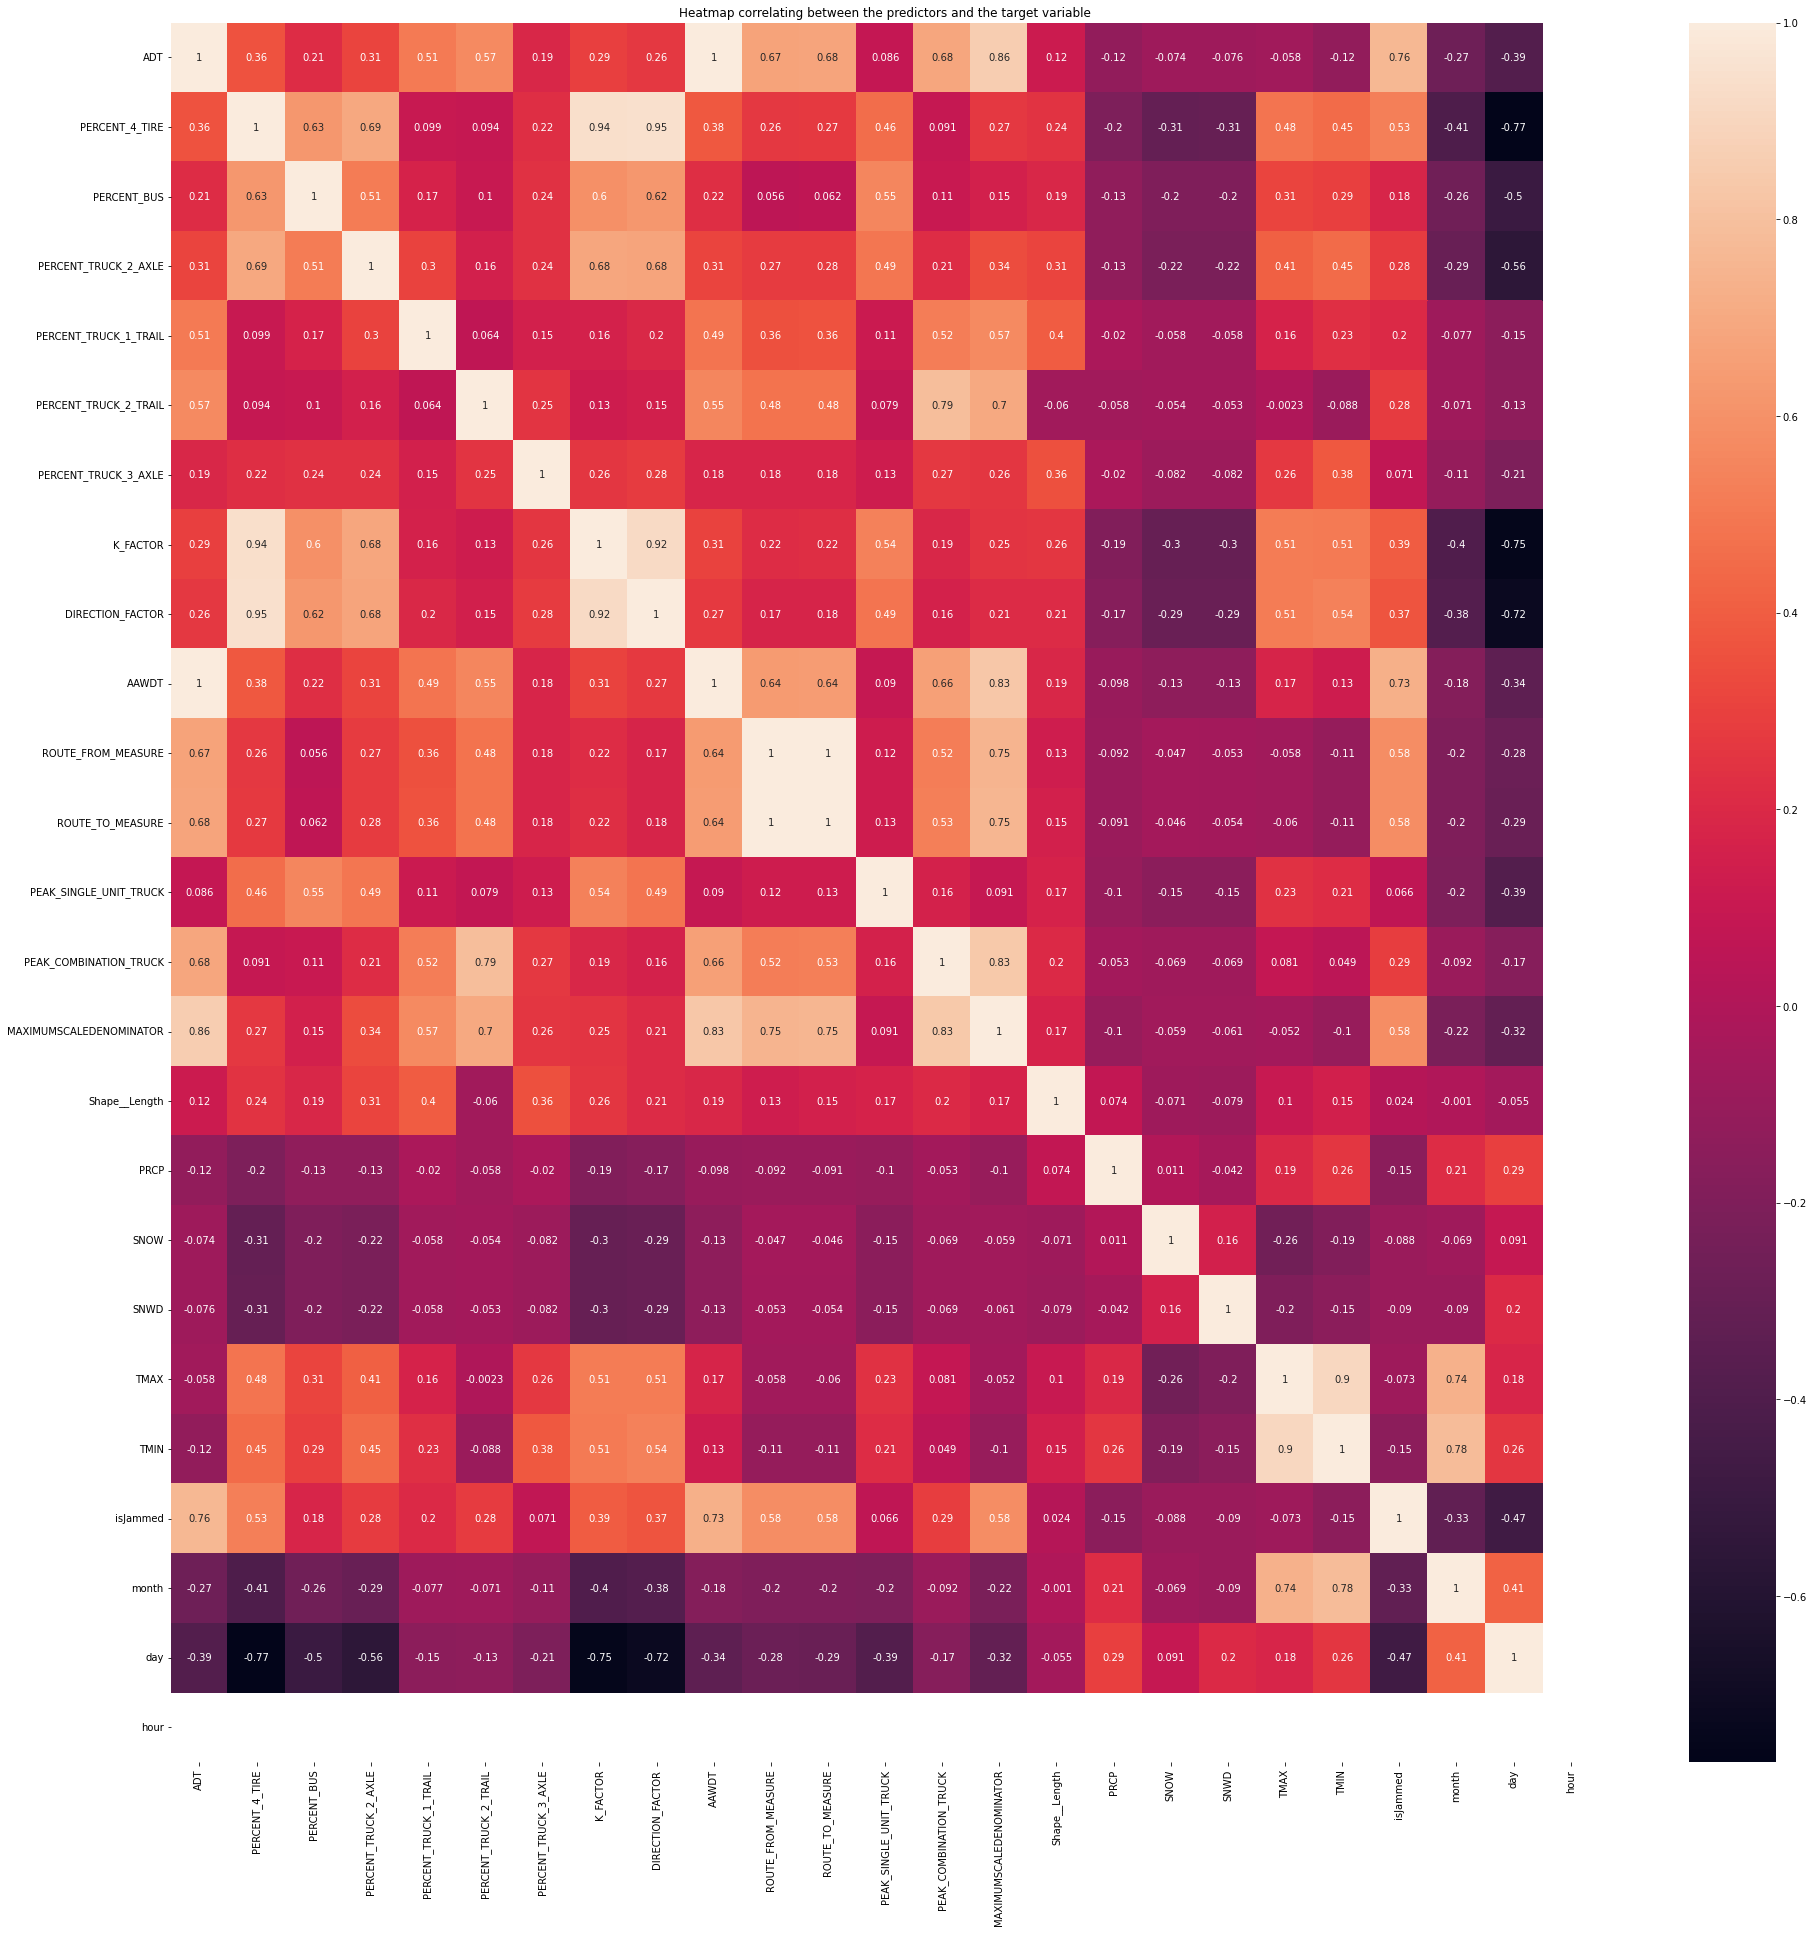

In [ ]:
print("################################# Traffic_Volume  ####################################")
# df1.info()

# creat a target class (isJammed )  
df1["isJammed"] = np.where(df1['ADT'] > df1["ADT"].mean() , 1,0 )

### split the date into year, nmonth, day, hour
# df1["DATE"] = pd.to_datetime(df1["DATE"], dayfirst=True, errors='coerce')
# df1['year'] = df1.DATE.dt.year
df1['month'] = df1.DATE.dt.month
df1['day'] = df1.DATE.dt.day
df1['hour'] = df1.DATE.dt.hour
df1.drop(['DATE'], axis=1, inplace=True)
df1.info()

# heat map
f, ax = plt.subplots(figsize=(32, 32))
ax.title.set_text('Heatmap correlating between the predictors and the target variable')
sns.heatmap(df1.corr(), annot=True)
plt.show()

# print(df1["DATE"].value_counts())

# df1["DATE"] = pd.to_datetime(df1["DATE"], dayfirst=True, errors='coerce')
# print(df1["DATE"].value_counts())
# # data['year'] = 
# print(df1.DATE.dt.year)
# # data['month'] = data.date.dt.month
# print(df1.DATE.dt.month)
# print(df1.DATE.dt.day)
# print(df1.DATE.dt.hour)
# data['day'] = data.date.dt.day


In [ ]:



print("################################# Streets  ####################################")
# df2.info()

# # introduce new feature average daily traffic (ADT) based on annual average daily traffic (AADT) 
# df2['ADT'] = (df2['AADT'] / 365).round(2)
# print(df2["VDOT_Accept_Date"].value_counts())

# print("################################# VDOT_Posted_Speed_Limits  ####################################")
# df3.info()

# df3.info()

# print("Town of Blacksburg",df3['FROM_JURISDICTION'].value_counts()['Town of Blacksburg'])
# print("Montgomery County",df3['FROM_JURISDICTION'].value_counts()['Montgomery County'])
# print(df3["STUDY_DATE"].value_counts())

# print("################################# TAADT_150_Blacksburg_2021  ####################################")
# df4.info()

# print(df4["AADT"].mean())
# print(df4["Data Date"].value_counts())

# df4["Data Date"].value_counts()

# print("################################# Traffic_Volume  ####################################")
# for i in col_names1:
#   print("for the ",i,":")
#   for j in df1[i].tolist():
#    print(j)

# print("################################# Streets  ####################################")
# for i in col_names2:
#   print("for the ",i,":")
#   for j in df2[i].tolist():
#    print(j)

# print("################################# VDOT_Posted_Speed_Limits  ####################################")
# for i in col_names3:
#   print("for the ",i,":")
#   for j in df3[i].tolist():
#    print(j)

# print("################################# TAADT_150_Blacksburg_2021  ####################################")
# for i in col_names4:
#   print("for the ",i,":")
#   for j in df4[i].tolist():
#    print(j)

# print("################################# Traffic_Volume  ####################################")
# for i in col_names1:
#   print("for the ",i,":")
#   # print(df1[i].value_counts())

# print("################################# streets  ####################################")
# for i in col_names2:
#   print("for the ",i,":")
#   print(df2[i].value_counts())

# print("################################# VDOT_Posted_Speed_Limits  ####################################")
# for i in col_names3:
#   print("for the ",i,":")
#   print(df3[i].value_counts())

# print("################################# TAADT_150_Blacksburg_2021  ####################################")
# for i in col_names4:
#   print("for the ",i,":")
#   print(df4[i].value_counts())

# # value_counts()
# marks_list = df1['FROM_JURISDICTION'].tolist()
# for i in marks_list:
#   print(i)
# # df1.info()
# # print(df1.head(5))

# print("Town of Blacksburg",df1['FROM_JURISDICTION'].value_counts()['Town of Blacksburg'])
# print("Montgomery County",df1['FROM_JURISDICTION'].value_counts()['Montgomery County'])

# new_df = df1[df1['FROM_JURISDICTION'] =='Town of Blacksburg']

# new_df.shape

# f, ax = plt.subplots(figsize=(15, 15))
# ax.title.set_text('Heatmap correlating between the predictors and the target variable')
# sns.heatmap(df_2.corr(), annot=True)
# plt.show()

# Selecting all the rows from the given dataframe 

# rslt_df = dataframe[dataframe['Percentage'] > 80]

# df_full['class'] = np.where( ( (df_full['discount'] > 20) & (df_full['tax'] == 0 ) & (df_full['total'] > 100) & df_full['productdiscount'] ) , 1, 0)

# Add new column to Python Pandas DataFrame based on multiple conditions [duplicate]

######################    Split date column into Year, Month and Day columns
# data['date']= pd.to_datetime(data['date'], dayfirst=True, errors='coerce')
# data['year'] = data.date.dt.year
# data['month'] = data.date.dt.month
# data['day'] = data.date.dt.day
# data['year'] = data['year'].fillna(0)
# data['year'] = data['year'].apply(np.int64)
# data['month'] = data['month'].fillna(0)
# data['month'] = data['month'].apply(np.int64)
# data['day'] = data['day'].fillna(0)
# data['day'] = data['day'].apply(np.int64)

################################# Streets  ####################################


## Feature Encoding

In [ ]:
# import the train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
encoders = dict()
df1 = df1.fillna(0)
dup_final_data = df1.copy()
for col in df1:
  # print(f"{df1[col]=}")
  print(f"{col=}")
  encoders[col] = preprocessing.LabelEncoder().fit(df1[col])
#
for col in dup_final_data:
  dup_final_data[col] = encoders[col].transform(dup_final_data[col])

col='ADT'
col='PERCENT_4_TIRE'
col='PERCENT_BUS'
col='PERCENT_TRUCK_2_AXLE'
col='PERCENT_TRUCK_1_TRAIL'
col='PERCENT_TRUCK_2_TRAIL'
col='PERCENT_TRUCK_3_AXLE'
col='K_FACTOR'
col='K_FACTOR_QUALITY_CODE'
col='DIRECTION_FACTOR'
col='AAWDT'
col='AAWDT_QUALITY_CODE'
col='LOC_COMP_DIRECTIONALITY_NAME'
col='ROUTE_FROM_MEASURE'
col='FROM_JURISDICTION'
col='ROUTE_TO_MEASURE'
col='TO_JURISDICTION'
col='PEAK_SINGLE_UNIT_TRUCK'
col='PEAK_COMBINATION_TRUCK'
col='MAXIMUMSCALEDENOMINATOR'
col='Shape__Length'
col='PRCP'
col='SNOW'
col='SNWD'
col='TMAX'
col='TMIN'
col='isJammed'
col='month'
col='day'
col='hour'


##Training and Prediction

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import eli5
import json
REGRESSORS = []
models = dict()
REGRESSORS.append(('DecisionTree', DecisionTreeClassifier(random_state=0, max_depth=None),
            {'max_depth': [None,1,2,3,4,5,6], #Tested with 3, 5, 1
             'splitter': ['best','random'],
            'max_features': ['auto'], #Tested with sqrt and log2 as well
            'min_samples_split': [2,4,6,50], 
            'random_state': [0]
        }))

REGRESSORS.append(('GaussinaNaiveBayes', GaussianNB(), {'var_smoothing': [1e-9,1e-8,1e-7,1e-6]}))
REGRESSORS.append(('LogisticRegression', LogisticRegression(random_state=0), {'penalty': ['l1', 'l2', 'elasticnet', 'none']}))

In [201]:


dup_final_data.fillna(0, inplace=True)
# print(train_X_set)
train_X_set, test_X_set = train_test_split(dup_final_data, test_size=0.2, random_state=42)
# create a k-means model with 3 clusters
train_y = train_X_set['isJammed']
test_y = test_X_set['isJammed']
train_X_set.drop(['isJammed', 'ADT', 'month', 'day', 'hour'], axis=1, inplace=True)
test_X_set.drop(['isJammed', 'ADT', 'month', 'day', 'hour'], axis=1, inplace=True)
scaler_x_train = preprocessing.StandardScaler().fit(train_X_set)
scaled_X_train = scaler_x_train.transform(train_X_set)

scaler_x_test = preprocessing.StandardScaler().fit(test_X_set)
scaled_X_test = scaler_x_test.transform(test_X_set)

for (label, raw_clf, hyperparams) in REGRESSORS:
   clf = GridSearchCV(raw_clf, hyperparams,scoring='f1',cv=5, refit=True)
   clf.fit(scaled_X_train, train_y)
   models[label] = clf.best_estimator_
   print(f"{label} best params: {clf.best_params_}")

results_training = dict()

results_testing = dict()
for estimator in models:
  print(f"Running {estimator} on training data and validation set")
  results_training[estimator] = {}
  results_testing[estimator] = {}
  models[estimator].fit(scaled_X_train, train_y)
  result = models[estimator].predict(scaled_X_train)
  train_results = (precision, recall, fscore, support) = precision_recall_fscore_support(result, train_y, average='macro')
  results_training[estimator]['precision'] = precision
  results_training[estimator]['recall'] = recall
  results_training[estimator]['fscore'] = fscore
  print('Training set Precision: {}\tRecall: {}\tfscore:{}'.format(precision, recall, fscore))
  y_pred = models[estimator].predict(scaled_X_test)
  (precision, recall, fscore, support) = precision_recall_fscore_support(test_y, y_pred, average='macro')
  results_testing[estimator]['precision'] = precision
  results_testing[estimator]['recall'] = recall
  results_testing[estimator]['fscore'] = fscore
  print('Validation set Precision: {}\tRecall: {}\tfscore:{}\n'.format(precision, recall, fscore))
# fit the model to the data
# kmeans.fit(train_set)

# predict the cluster labels for new data
# new_clusters = kmeans.predict(test_set)

DecisionTree best params: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 4, 'random_state': 0, 'splitter': 'best'}
GaussinaNaiveBayes best params: {'var_smoothing': 1e-06}


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lb

LogisticRegression best params: {'penalty': 'none'}
Running DecisionTree on training data and validation set
Training set Precision: 1.0	Recall: 1.0	fscore:1.0
Validation set Precision: 0.9973958333333333	Recall: 0.9918032786885246	fscore:0.9945622855663208

Running GaussinaNaiveBayes on training data and validation set
Training set Precision: 0.890745501285347	Recall: 0.7875	fscore:0.8037518037518037
Validation set Precision: 0.37896825396825395	Recall: 0.5	fscore:0.4311512415349887

Running LogisticRegression on training data and validation set
Training set Precision: 1.0	Recall: 1.0	fscore:1.0
Validation set Precision: 0.9922680412371134	Recall: 0.9754098360655737	fscore:0.9834988540870894



In [ ]:
print(results)

{'DecisionTree': {'training': {'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}, 'testing': {'precision': 0.9973958333333333, 'recall': 0.9918032786885246, 'fscore': 0.9945622855663208}}, 'GaussinaNaiveBayes': {'training': {'precision': 0.890745501285347, 'recall': 0.7875, 'fscore': 0.8037518037518037}, 'testing': {'precision': 0.37896825396825395, 'recall': 0.5, 'fscore': 0.4311512415349887}}, 'LogisticRegression': {'training': {'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}, 'testing': {'precision': 0.9922680412371134, 'recall': 0.9754098360655737, 'fscore': 0.9834988540870894}}}


In [ ]:
training_results = pd.DataFrame(results_training)
testing_results = pd.DataFrame(results_testing)

In [ ]:
training_results.style

In [ ]:
testing_results.style

In [ ]:
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=2)
kmeans.fit(train_X_set)
new_clusters = kmeans.predict(test_X_set)

# Print the cluster labels for each point
# print(new_clusters.labels_)

# Print the coordinates of the cluster centers
# Print the cluster labels for each point
print(kmeans.labels_)
labels = ['Not_Jammed', 'Jammed']
# Print the coordinates of the cluster centers
print(kmeans.cluster_centers_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=['r', 'b'])
#  
# u_labels = np.unique(new_clusters)
#  
# for i in u_labels:
#     plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
# plt.legend()
# plt.show()
# print(new_clusters)

In [ ]:
new_clusters

In [ ]:
train_X_set.columns

In [207]:
'''
Gathers feature importance for each model from ELI5
Saves the feature importances for each model in feature_importances.json
@param models - the models to determine feature importance for
@param features - the name of the features
'''
def retrieve_eli5_stats(models, features):
    model_importances = dict()
    for model in models:
        # print(model)
        weights = eli5.explain_weights(models[model], feature_names=features)
        dictForm = eli5.formatters.as_dict.format_as_dict(weights)
        # print(dictForm)
        # if (dictForm['error'] is not None):
        #   print(dictForm['error'])
        #   continue
        # importances = dictForm['feature_importances']['importances']

        model_importances[model] = dictForm
        # break
    json.dump(model_importances, open(f'feature_importances.json', 'w'))
    return model_importances


In [208]:
feature_names = [feat for feat in train_X_set.columns]
feature_names

['PERCENT_4_TIRE',
 'PERCENT_BUS',
 'PERCENT_TRUCK_2_AXLE',
 'PERCENT_TRUCK_1_TRAIL',
 'PERCENT_TRUCK_2_TRAIL',
 'PERCENT_TRUCK_3_AXLE',
 'K_FACTOR',
 'K_FACTOR_QUALITY_CODE',
 'DIRECTION_FACTOR',
 'AAWDT',
 'AAWDT_QUALITY_CODE',
 'LOC_COMP_DIRECTIONALITY_NAME',
 'ROUTE_FROM_MEASURE',
 'FROM_JURISDICTION',
 'ROUTE_TO_MEASURE',
 'TO_JURISDICTION',
 'PEAK_SINGLE_UNIT_TRUCK',
 'PEAK_COMBINATION_TRUCK',
 'MAXIMUMSCALEDENOMINATOR',
 'Shape__Length',
 'PRCP',
 'SNOW',
 'SNWD',
 'TMAX',
 'TMIN']

In [209]:
model_importances = retrieve_eli5_stats(models, feature_names)

In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [218]:
import graphviz


NameError: ignored

In [212]:
graph = graphviz.Source(model_importances['DecisionTree']['decision_tree']['graphviz'])

In [217]:
graph.render('decision_tree', format='png')

'decision_tree.png'